# Pathological Voices Detection

## Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
import cv2
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold
from sklearn.svm import SVC

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict

from joblib import dump

## Example

Here, we upload and plot a single voice signal from the ".txt" file of subject 1:

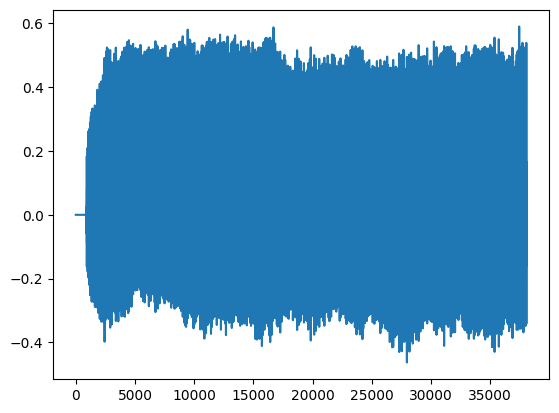

In [2]:
df1 = pd.read_csv("C:/Users/aless/Desktop/opencv competition/VOICED DATASET/voice001.txt",  delimiter='\t')
plt.plot(df1)
plt.show()

We transform the Pandas Series into a Numpy array and apply the Gramian angular Summation field, the resulting image will have the following shape:

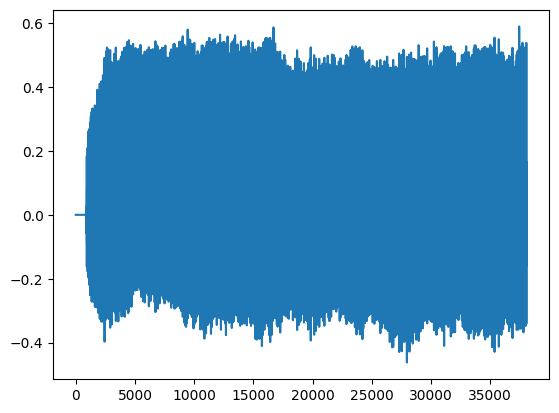

In [4]:
signal1 = df1.values
scaler = StandardScaler(with_std=False)
scaled = scaler.fit_transform(signal1)
plt.plot(scaled)
plt.show()

In [5]:
dump(scaler, 'C:/Users/aless/Desktop/opencv competition/scaler.joblib') 

['C:/Users/aless/Desktop/opencv competition/scaler.joblib']

In order to plot the resulting gray image, the function need that the array is of shape (H x W x C). But first, image should be standardized to be integer pixels in range [0, 255].

(1, 128, 128)


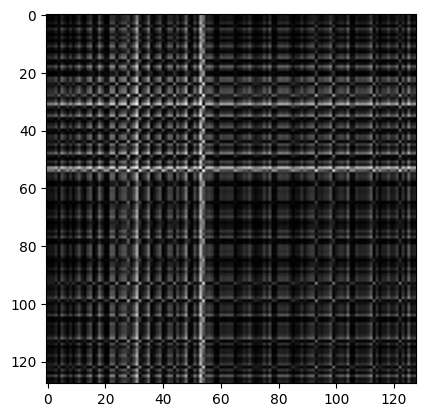

In [6]:
signal2 = np.transpose(signal1)
gasf = GramianAngularField(method='summation', image_size=128)
img = gasf.transform(signal2)
print(img.shape)

min_val = np.min(img)
max_val = np.max(img)
img = 255 * ((img - min_val) / (max_val - min_val))
img = img.astype(np.uint8)

img = img.transpose(1,2,0)
plt.imshow(img, cmap='gray')
plt.show()

The HOG features are extracted from a 128 x 128 version on the whole image, with a cell of size 2x2 and block of size 8x8 which goes throw the image by 4 blocks and 18 bins.

In [7]:
image = cv2.resize(img, (128, 128))
win_size = image.shape
cell_size = (4, 4)
block_size = (8, 8)
block_stride = (4, 4)
num_bins = 18
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)
features = hog.compute(image)
print(features.shape)

(69192,)


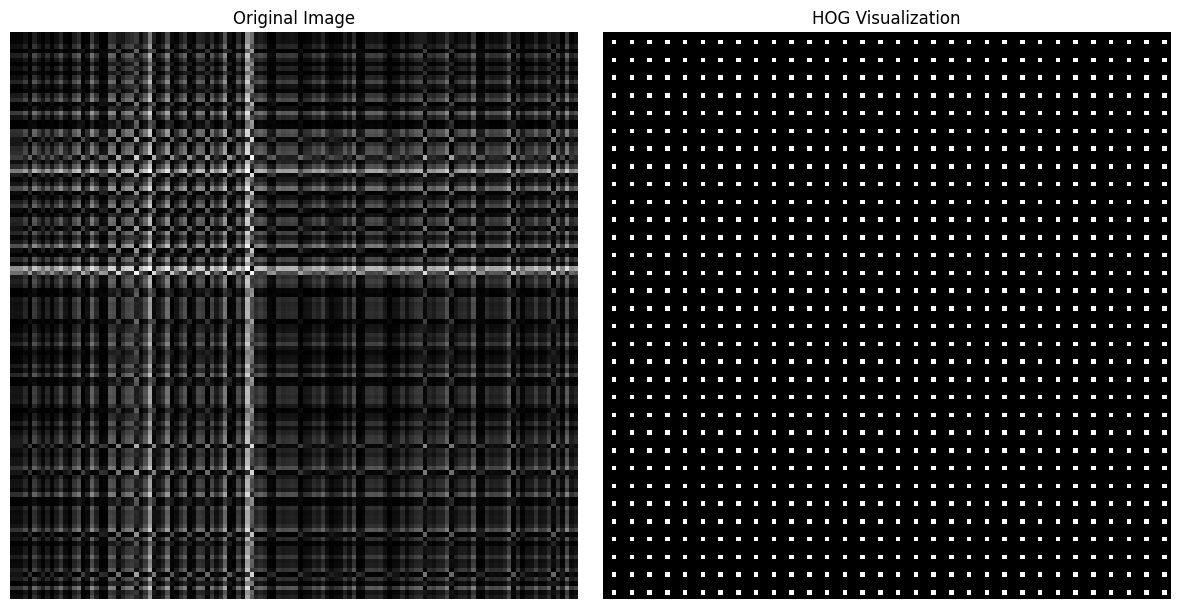

In [8]:
# Reshape the HOG features into a 2D array
hog_features = features.reshape(-1, num_bins)

# Create a blank image to visualize HOG features
hog_image = np.zeros((128, 128), dtype=float)

# Iterate through HOG features and draw HOG descriptors as gradients
cell_size_x, cell_size_y = cell_size
for i in range(hog_features.shape[0]):
    for j in range(num_bins):
        magnitude = hog_features[i][j]
        angle_radians = j * np.pi / num_bins
        x = int(i % (128 / cell_size_x)) * cell_size_x + cell_size_x // 2
        y = int(i // (128 / cell_size_y)) * cell_size_y + cell_size_y // 2
        x1 = x + int(magnitude * np.cos(angle_radians) * cell_size_x / 2)
        y1 = y + int(magnitude * np.sin(angle_radians) * cell_size_y / 2)
        cv2.line(hog_image, (y, x), (y1, x1), 255, 1)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original image on the right
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Plot the HOG image on the left
axes[1].imshow(hog_image, cmap='gray')
axes[1].set_title('HOG Visualization')
axes[1].axis('off')

plt.tight_layout()
plt.show()


Right image represents the original GASF image of subject 1, left image represents the HOG features: the higher the most important. From the HOG image it's possible to detect some circle pattern highlighting the most important part of the image. 

## Saving Gramian Angular Field Images

In this part of the code I extract the signal from a folder, apply GAF function and save images into another folder divided by labels.

In [9]:
source_folder = "C:/Users/aless/Desktop/opencv competition/VOICED DATASET"
target_folder = "C:/Users/aless/Desktop/opencv competition/imgs"

# Create the target folder if it doesn't exist
os.makedirs(target_folder, exist_ok=True)

# List all files in the source folder
file_list = os.listdir(source_folder)

In [10]:
for filename in tqdm(file_list, desc="Processing files"):
    if filename.endswith('.txt'):
        # Read the data from the file
        file_path = os.path.join(source_folder, filename)
        data = pd.read_csv(file_path,  delimiter='\t')

        array = data.values
        array = np.transpose(array)
        
        gasf = GramianAngularField(method='summation', image_size=128)
        img = gasf.transform(array)
        
        # Save the produced image in the target folder as jpg
        target_path = os.path.join(target_folder, filename.replace('.txt', '.jpg'))

        # Convert numpy array to PIL Image and save as jpg
        img = img.reshape((128, 128))  # Reshape to (128 x 128)
        img = (img - img.min()) / (img.max() - img.min()) * 255 #ensure range [0, 255]
        img = img.astype(np.uint8)
        pil_img = Image.fromarray(img, mode='L')  # 'L' mode for grayscale
        pil_img.save(target_path)

Processing files: 100%|██████████| 208/208 [00:12<00:00, 16.85it/s]


## Preprocessing

In [11]:
print('Folders inside the main directory: ', os.listdir("C:\\Users\\aless\\Desktop\\opencv competition\\imgs"))

Folders inside the main directory:  ['healthy', 'pathological']


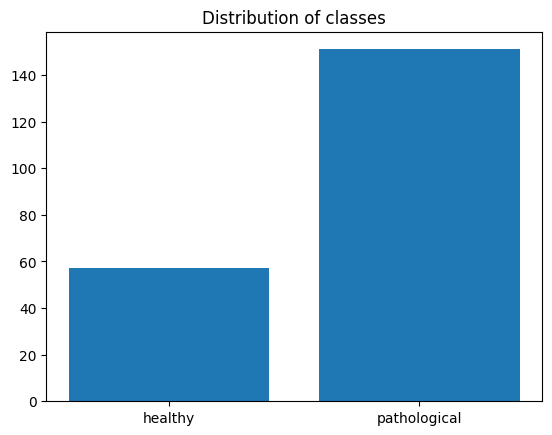

In [12]:
classes = os.listdir("C:\\Users\\aless\\Desktop\\opencv competition\\imgs")
sum_images = []
for i in classes:
    img_base_path = "C:\\Users\\aless\\Desktop\\opencv competition\\imgs/" + str(i)
    images = os.listdir(img_base_path)
    sum_images.append(len(images))
plt.bar(classes, sum_images)
plt.title('Distribution of classes')
plt.show()

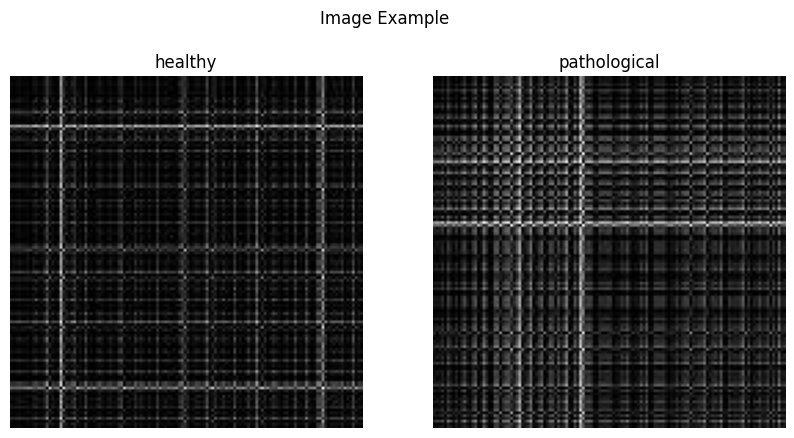

In [13]:
images = []
paths = []

fig,ax = plt.subplots(1,2,figsize = (10, 5))
ax = ax.ravel()

for idx, i in enumerate(classes):
    img_base_path = "C:\\Users\\aless\\Desktop\\opencv competition\\imgs/" + str(i) #link of the subfolders
    timages = os.listdir(img_base_path) #list of images inside each subfolders
    images_path_to_display = os.path.join(img_base_path, str(timages[0]))
    paths.append(images_path_to_display)
    img = Image.open(images_path_to_display)
    images.append(img)
    image = images[idx]
    ax[idx].axis('off')
    ax[idx].imshow(image,cmap = 'gray')
    ax[idx].set_title(str(i))

plt.suptitle('Image Example')
plt.show()

## OpenCV

In [14]:
# Specify the parameters for our HOG descriptor
win_size = (128, 128)
cell_size = (4, 4)
block_size = (8, 8)
block_stride = (4, 4)
num_bins = 18

# Set the parameters of the HOG descriptor using the variables defined above
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)

In [15]:
# Initialize variables
img_folder_1 = 'C:\\Users\\aless\\Desktop\\opencv competition\\imgs\\healthy'
img_folder_2 = 'C:\\Users\\aless\\Desktop\\opencv competition\\imgs\\pathological'

imgs = []
labels = []

# Process images in folder 1
for img_name in os.listdir(img_folder_1):
    img_path = os.path.join(img_folder_1, img_name)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    if img is not None:
        img_hog = hog.compute(img)
        imgs.append(img_hog)
        labels.append(0)

# Process images in folder 2
for img_name in os.listdir(img_folder_2):
    img_path = os.path.join(img_folder_2, img_name)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    if img is not None:
        img = hog.compute(img)
        imgs.append(img)
        labels.append(1)

# Convert the lists to NumPy arrays
imgs = np.array(imgs)
labels = np.array(labels)

# Print the shape of the arrays to verify
print("Images shape:", imgs.shape)
print("Labels shape:", labels.shape)

Images shape: (208, 69192)
Labels shape: (208,)


There are 208 images from which a vector of features of size 276,768 has been extracted. Labels instead remains the same.

## Training

Here, I balance the dataset with SMOTE technique and scale the features in range [0, 1]

In [16]:
balancing = SMOTE(sampling_strategy= 'minority', random_state=46)
X, y = balancing.fit_resample(imgs, labels)
print(X.shape)
print(y.shape)

scaler = MinMaxScaler()
x = scaler.fit_transform(X)

  File "c:\Users\aless\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\aless\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aless\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\aless\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


(302, 69192)
(302,)


In [17]:
dump(scaler, 'C:/Users/aless/Desktop/opencv competition/scaler2.joblib')

['C:/Users/aless/Desktop/opencv competition/scaler2.joblib']

In [18]:
clf = SVC(random_state=46, kernel='linear', gamma = 0.0)
cv = StratifiedKFold(shuffle=True, random_state=42)
param_grid = [{'C': [0.0001, 0.001, 0.01, 1, 10, 100]}]
search = HalvingGridSearchCV(clf, param_grid, cv = cv, random_state=42, scoring = 'f1', verbose=3, refit=True).fit(x, y)
print(search.best_params_)
print(search.best_score_) 

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 100
max_resources_: 302
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 100
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ......C=0.0001;, score=(train=0.987, test=0.600) total time=   1.8s
[CV 2/5] END ......C=0.0001;, score=(train=0.348, test=0.000) total time=   1.7s
[CV 3/5] END ......C=0.0001;, score=(train=0.741, test=0.560) total time=   1.6s
[CV 4/5] END ......C=0.0001;, score=(train=0.835, test=0.560) total time=   1.7s
[CV 5/5] END ......C=0.0001;, score=(train=0.775, test=0.500) total time=   1.9s
[CV 1/5] END .......C=0.001;, score=(train=1.000, test=0.545) total time=   1.9s
[CV 2/5] END .......C=0.001;, score=(train=1.000, test=0.933) total time=   1.9s
[CV 3/5] END .......C=0.001;, score=(train=1.000, test=0.714) total time=   2.2s
[CV 4/5] END .......C=0.001;, score=(train=1.000, test=0.706) total time=   1.7s
[CV 5/5] END 

Support Vector Classifier with linear kernel and regularization of strength 10 produced 93.3% of F1 with 5 fold cross-validation technique.

In [19]:
clf = search.best_estimator_
y_pred = cross_val_predict(clf, x, y, cv=cv)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       151
           1       0.96      0.90      0.93       151

    accuracy                           0.93       302
   macro avg       0.93      0.93      0.93       302
weighted avg       0.93      0.93      0.93       302



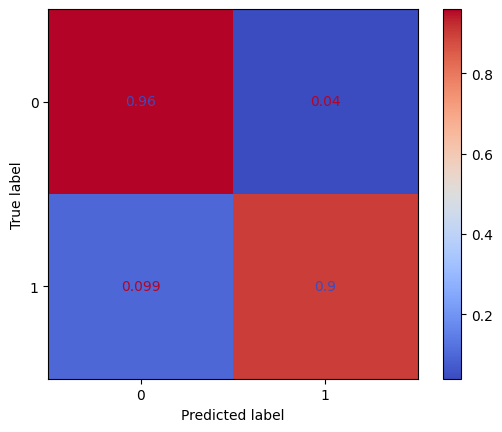

In [20]:
ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='coolwarm', normalize = 'true')
plt.show()

In particular, there are more Type-I error than Type-II error, which is an optimal result. In the code below I saved the trained model.

In [29]:
dump(clf, 'C:/Users/aless/Desktop/opencv competition/clf.joblib') 

['C:/Users/aless/Desktop/opencv competition/clf.joblib']